# Optimization Problem

The optimization problem can be written as:

$$
\text{min} \quad \sum_{t} \left( r x_t + q u_t \right)
$$

Subject to the following constraints:

$$
u_t + k s_t = G_t \quad \forall t \quad \text{(Demand constraint)}
$$

$$
c_{t+1} = c_t + s_t \quad \forall t \quad \text{(Storage evolution)}
$$

$$
c_T = c_0 \quad \text{(Final charge constraint)}
$$

$$
x_{t+1} = x_t + L_t - u_t \quad \forall t \quad \text{(Workload evolution)}
$$


$$
x_T = 0 \quad \text{(Backlog clearance)}
$$

$$
x_t, c_t, u_t \geq 0 \quad \forall t \quad \text{(Non-negativity)}
$$


Where:
- \( x_t \): backlog or deferred workload at time \( t \)
- \( u_t \): amount of workload processed at time \( t \)
- \( r \): cost per unit of backlog — penalizes unprocessed/delayed work
- \( q \): cost per unit of processing — energy, labor, or other operational costs
- \( L_t \): new workload arriving at time \( t \)


## Constraints

### Demand Constraint:
$$
u_t + k s_t = G_t \quad \forall t
$$

Where:
- \( G_t \): power consumption (e.g., grid energy) at time \( t \)
- \( s_t \): power stored into battery at time \( t \)
- \( k \): conversion factor between storage and power (e.g., efficiency)

### Storage Evolution:
$$
c_{t+1} = c_t + s_t \quad \forall t
$$

### Final Charge Constraint:
$$
c_T = c_0
$$

### Workload Evolution:
$$
x_{t+1} = x_t + L_t - u_t \quad \forall t
$$

Where:
- \( L_t \): new workload arriving at time \( t \)

### Backlog Clearance:
$$
x_T = 0
$$

### Non-Negativity:
$$
x_t \geq 0, \quad c_t \geq 0, \quad u_t \geq 0 \quad \forall t
$$

## Summary
This linear program determines:
- Workload processing decisions (\( u_t \))
- Energy usage and storage (\( s_t \), \( c_t \))
- Backlog management (\( x_t \))

All while minimizing the total cost from both deferred (\( r x_t \)) and completed work (\( q u_t \)), under operational and physical constraints.


# Incorporating Cooling

We assume that all electricity used for computing purposes is generated into heat, and the heat removed/cooled is the same as the heat generated:

$$
\dot{Q}_{load} = \dot{W}_{computing} = \dot{Q}_{cooling}
$$

Thus, 
$$
P_{chiller}(t) = \frac{\dot{Q}_{cooling}(t)}{COP(T_{ambient}(t))}
$$

From literature (Yu 2005 and Zhang 2024), we determine a relationship between COP and ambient temperature:
$$
COP(T_{ambient}(t)) = COP_{ref} \cdot (1-0.02(T_{ambient} - T_{ref}))
$$

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def find_data_start_line(file_path):
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if line.startswith('DATA PERIODS'):
                # Data starts on the next line
                return i + 2

# Path to your .epw file

# Column names for EPW hourly data (standard 35 fields)
column_names = [
    "Year", "Month", "Day", "Hour", "Minute", "Data Source and Uncertainty Flags",
    "Dry Bulb Temperature [C]", "Dew Point Temperature [C]", "Relative Humidity [%]",
    "Atmospheric Station Pressure [Pa]", "Extraterrestrial Horizontal Radiation [Wh/m2]",
    "Extraterrestrial Direct Normal Radiation [Wh/m2]",
    "Horizontal Infrared Radiation Intensity [Wh/m2]", "Global Horizontal Radiation [Wh/m2]",
    "Direct Normal Radiation [Wh/m2]", "Diffuse Horizontal Radiation [Wh/m2]",
    "Global Horizontal Illuminance [lux]", "Direct Normal Illuminance [lux]",
    "Diffuse Horizontal Illuminance [lux]", "Zenith Luminance [Cd/m2]",
    "Wind Direction [degrees]", "Wind Speed [m/s]", "Total Sky Cover [tenths]",
    "Opaque Sky Cover [tenths]", "Visibility [km]", "Ceiling Height [m]",
    "Present Weather Observation", "Present Weather Codes", "Precipitable Water [mm]",
    "Aerosol Optical Depth [thousandths]", "Snow Depth [cm]", "Days Since Last Snowfall",
    "Albedo", "Liquid Precipitation Depth [mm]", "Liquid Precipitation Quantity [hr]"
]

def shift_from_utc(data, offset_hours):
    """
    Shift a list of 24 hourly values from UTC to a timezone that is `offset_hours`
    behind UTC.

    """
    # roll left by offset_hours:
    k = offset_hours % 24
    return data[k:] + data[:k]


def get_data(energy_path,weather_path, offset, DC_wind_cap, DC_solar_cap, iso_wind_cap, iso_solar_cap):
    """
    Loads renewable generation and carbon intensity data, and computes
    DC-area wind and solar generation adjusted for UTC offset.

    Parameters:
        path (str): Path to CSV file containing renewable generation data.
        offset (int): Hours to shift from UTC.
        DC_wind_cap (float): DC-area wind capacity.
        DC_solar_cap (float): DC-area solar capacity.
        iso_wind_cap (float): ISO-wide wind capacity.
        iso_solar_cap (float): ISO-wide solar capacity.

    Returns:
        tuple: Shifted DC wind generation, DC solar generation, and grid carbon intensity (lists).
    """
    renewable_gen = pd.read_csv(energy_path)
    skip_rows = find_data_start_line(weather_path)
    weather_data = pd.read_csv(weather_path, skiprows=skip_rows, header=None, names=column_names)
    temperature = weather_data["Dry Bulb Temperature [C]"].to_list()

    iso_wind = renewable_gen["WND"]
    iso_solar = renewable_gen["SUN"]

    # Normalize ISO generation and scale to DC capacities
    DC_wind_gen = shift_from_utc(((iso_wind / iso_wind_cap) * DC_wind_cap).tolist(), offset)
    DC_solar_gen = shift_from_utc(((iso_solar / iso_solar_cap) * DC_solar_cap).tolist(), offset)

    # Shift carbon intensity values
    grid_carbon = shift_from_utc(renewable_gen["avg_CI"].tolist(), offset)

    return DC_wind_gen, DC_solar_gen, grid_carbon, temperature

import pandas as pd
import numpy as np

def interpolate_array(arr):
    """
    Takes a list with numeric values and missing entries (None, np.nan, or non-numeric strings),
    and returns a new list with linear interpolation filling in the missing values.
    """
    # Convert to pandas Series, coerce bad values to NaN
    series = pd.to_numeric(pd.Series(arr), errors='coerce')

    # Interpolate missing values
    interpolated = series.interpolate()

    # Optional: fill any NaNs at the start or end
    interpolated = interpolated.fillna(method='bfill').fillna(method='ffill')

    return interpolated.tolist()

def interp(list):
    for index, value in enumerate(list):
        if np.isnan(value):
            list[index] = (list[index-1]+list[index+1])/2
    return list

price_per_MWh = 40
SCC = 190
renewable_path = "data/CarbonIntensity/CAISO_NG_&_avgCI.csv"
weather_path = 'data/Weather/USA_CA_San.Jose-Mineta.epw'
T = 24*365-1
W, S, C, T_amb = get_data(renewable_path, weather_path, 8 , 100,500,6200,21000,)
C = interpolate_array(C)
Carbon_ton_mwh = [C[i]/1e3 for i in range(len(C)) ]
T_amb = np.array(T_amb[:T])

In [126]:
load_path = "data/Workload/load_profile_template_edited(Google).csv"
load = pd.read_csv(load_path)
load.head()
load_kw = load["Load (kW)"]
L = (load_kw/1000).to_list()
L=L[:T]


### Helper functions (for visualizations)

In [127]:
def plot_results(title, served, load, soc=None, generation=None, backlog=None,
                 carbon_intensity=None, emissions=None):

    T = len(served)
    L=load[:T]
    total_demand = sum(L)
    total_served = sum(served)
    total_emissions = sum(emissions) if emissions else None

    # Collect secondary plots
    secondary_plots = []
    if generation: secondary_plots.append(('Generation Over Time', generation[:T], 'Power (kW)', 'green'))
    if soc: secondary_plots.append(('Battery State of Charge', soc[:T], 'Stored Energy (% of Capacity)', 'purple'))
    if backlog: secondary_plots.append(('Backlog Over Time', backlog[:T], 'Energy(MW)', 'crimson'))
    if carbon_intensity: secondary_plots.append(('Carbon Intensity Over Time', carbon_intensity[:T], 'tons CO₂ / MWh', 'gray'))
    if emissions: secondary_plots.append(('Emissions Over Time', emissions[:T], 'tons CO₂', 'black'))

    num_rows = 1 + len(secondary_plots)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, 4 * num_rows), squeeze=False)

    # Plot 1: Load and Served
    ax_main = axs[0, 0]
    ax_main.plot(range(len(L)), L, marker="o", label="Load (Demand, MW)", color="blue")
    ax_main.plot(range(len(served)), served, marker="o", label="Served", color="orange")
    ax_main.fill_between(range(len(L)), 0, L, alpha=0.1, color="blue")
    ax_main.fill_between(range(len(served)), 0, served, alpha=0.2, color="orange")
    ax_main.set_title(title)
    ax_main.set_xlabel("Time Step")
    ax_main.set_ylabel("Energy")
    ax_main.grid(True)
    ax_main.legend()

    text = f"Total Demand = {total_demand:.1f}\nTotal Served = {total_served:.1f}"
    if total_emissions is not None:
        text += f"\nTotal Emissions = {total_emissions:.1f} kgCO₂"
    ax_main.text(len(L) - 2, max(max(L), max(served)) * 0.85,
                text, bbox=dict(facecolor='white', alpha=0.7), fontsize=11)

    # Plot each additional element in its own row
    for i, (title_i, data_i, y_label, color) in enumerate(secondary_plots, start=1):
        ax = axs[i, 0]
        ax.plot(range(len(data_i)), data_i, marker='o', color=color, label=title_i)
        ax.fill_between(range(len(data_i)), 0, data_i, color=color, alpha=0.15)
        ax.set_title(title_i)
        ax.set_xlabel("Time Step")
        ax.set_ylabel(y_label)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


def plot_duals_and_reduced_costs(duals, reduced_costs):
    time_range = range(len(next(iter(duals.values())))) if duals else range(len(next(iter(reduced_costs.values()))))

    # Plot all dual variables in one figure
    if duals:
        n_plots = len(duals)
        fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6 * n_plots))

        # If there's only one plot, axes is an array with one element. We handle that case separately
        if n_plots == 1:
            axes = [axes]

        # Plot each dual variable in a separate subplot
        colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
        i = 0
        for name, values in duals.items():
            ax = axes[i]
            ax.plot(time_range, values,color = colors[i], marker='o',linestyle='--', label=f"Dual: {name}")
            ax.set_title(f"Dual Variable: {name}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Dual Value")
            ax.grid(True)
            ax.legend()
            i += 1

        # Adjust layout and show all plots
        plt.tight_layout()
        plt.show()

    # Plot all reduced costs in a separate figure
    if reduced_costs:
        n_plots = len(reduced_costs)
        fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6 * n_plots))

        # If there's only one plot, axes is an array with one element. We handle that case separately
        if n_plots == 1:
            axes = [axes]

        # Plot each dual variable in a separate subplot
        i = 0
        for name, values in reduced_costs.items():
            ax = axes[i]
            ax.plot(range(len(values)), values,color = colors[i], marker='o',linestyle='--', label=f"Dual: {name}")
            ax.set_title(f"Reduced cost: {name}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Dual Value")
            ax.grid(True)
            ax.legend()
            i += 1

        # Adjust layout and show all plots
        plt.tight_layout()
        plt.show()


def plot_results_1(title, served, soc=None, second_plot=None, backlog=None,
                   carbon_intensity=None, emissions=None,
                   from_renewables=None, from_storage=None, from_grid=None,
                   duals=None, reduced_costs=None):

    total_demand = sum(L)
    total_served = sum(served)
    total_emissions = sum(emissions) if emissions else None

    # Secondary plots
    secondary_plots = []
    if second_plot: secondary_plots.append(('Generation Over Time', G, 'Power (kW)', 'green'))
    if soc: secondary_plots.append(('Battery State of Charge', soc, 'Stored Energy', 'purple'))
    if backlog: secondary_plots.append(('Backlog Over Time', backlog, 'Energy', 'crimson'))
    if carbon_intensity: secondary_plots.append(('Carbon Intensity Over Time', carbon_intensity, 'kg CO₂ / MWh', 'gray'))
    if emissions: secondary_plots.append(('Emissions Over Time', emissions, 'kg CO₂', 'black'))

    num_rows = 1 + len(secondary_plots)
    fig, axs = plt.subplots(num_rows, 1, figsize=(10, 4 * num_rows), squeeze=False)

    # Plot 1: Load and Served
    ax_main = axs[0, 0]
    time_range = range(len(L))
    ax_main.plot(time_range, L, marker="o", label="Load (Demand)", color="blue")
    ax_main.fill_between(time_range, 0, L, alpha=0.1, color="blue")

    # Prepare stacking if any source is present
    source_stack = []
    source_labels = []
    source_colors = []

    if from_renewables:
        source_stack.append(from_renewables)
        source_labels.append("Renewables")
        source_colors.append("lightgreen")

    if from_storage:
        if source_stack:
            stacked_storage = [source_stack[-1][i] + from_storage[i] for i in time_range]
        else:
            stacked_storage = from_storage
        source_stack.append(stacked_storage)
        source_labels.append("Storage")
        source_colors.append("purple")

    if from_grid:
        if source_stack:
            stacked_grid = [source_stack[-1][i] + from_grid[i] for i in time_range]
        else:
            stacked_grid = from_grid
        source_stack.append(stacked_grid)
        source_labels.append("Grid")
        source_colors.append("gray")

    # Plot stacked sources if any exist
    if source_stack:
        bottom = [0] * len(L)
        for i, top in enumerate(source_stack):
            ax_main.fill_between(time_range, bottom, top,
                                 label=source_labels[i],
                                 color=source_colors[i], alpha=0.6)
            bottom = top
        ax_main.plot(time_range, served, marker="o", color="orange", label="Served (Total)")
    else:
        ax_main.plot(range(len(served)), served, marker="o", label="Served", color="orange")
        ax_main.fill_between(range(len(served)), 0, served, alpha=0.2, color="orange")

    ax_main.set_title(title)
    ax_main.set_xlabel("Time Step")
    ax_main.set_ylabel("Energy")
    ax_main.grid(True)
    ax_main.legend()

    # Summary text
    text = f"Total Demand = {total_demand:.1f}\nTotal Served = {total_served:.1f}"
    if total_emissions is not None:
        text += f"\nTotal Emissions = {total_emissions:.1f} kgCO₂"
    ax_main.text(len(L) - 2, max(max(L), max(served)) * 0.85,
                 text, bbox=dict(facecolor='white', alpha=0.7), fontsize=11)

    # Plot additional variables
    for i, (title_i, data_i, y_label, color) in enumerate(secondary_plots, start=1):
        ax = axs[i, 0]
        ax.plot(range(len(data_i)), data_i, marker='o', color=color, label=title_i)
        ax.fill_between(range(len(data_i)), 0, data_i, color=color, alpha=0.15)
        ax.set_title(title_i)
        ax.set_xlabel("Time Step")
        ax.set_ylabel(y_label)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Plot duals and reduced costs separately
    if duals or reduced_costs:
        plot_duals_and_reduced_costs(duals, reduced_costs)


### Actual Scenarios

In [128]:
q = 1.0  # Cost per unit energy used
r = 200  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit =100 # float("inf") #or switch to actual computing limit
battery_limit = 300 # float("inf") # or switch to actual computing limit

## Grid Dependent

### No Job scheduling

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Input data (already loaded from previous context)
# Parameters

# Generation (G_t) over 10 time steps (e.g., hours of the day)
# G = [30, 40, 50, 60, 75, 90, 100, 80, 60, 40]  # Peak generation occurs midday and early evening

# # Load (L_t) over the same 10 time steps
# L = [35, 45, 50, 55, 70, 85, 90, 80, 65, 40]  # Load peaks during evening hours
# L = [
#     30, 25, 20, 20, 25, 35, 50, 60, 65, 60, 55, 50,
#     55, 65, 75, 85, 90, 95, 90, 70, 60, 50, 40, 35
# ]  # Computational Load sum = 1400
# G = [
#      0, 0, 0, 0, 7, 21, 50, 86, 114, 129, 143, 150,
#    143, 122, 86, 57, 29, 14, 7, 0, 0, 0, 0, 0
# ]  #Renewable Generation sum = 1526


In [130]:

# Assume all demand is served by the grid
CAPEX = 2100*1000

# Parameters
q = 1.0  # Cost per unit energy used
r =1  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit = 100 # float("inf") #or switch to actual computing limit
battery_limit = 4.07 # float("inf") # or switch to actual computing limit


hours = np.arange(T)
T_ref, COP_ref = 25.0, 4.0
# T_amb = T_ref + 5.0 * np.sin((hours - 15)/24 * 2*np.pi)
COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

m1 = gp.Model("Grid + Storage w/ Optimal Scheduling")
m1.setParam("OutputFlag", 0)

u_g = m1.addVars(T, name="u_g", lb=0)
P_chiller = m1.addVars(T, name="P_chiller", lb=0)
u = m1.addVars(T, name="u", lb=0)

# Add constraints
m1.addConstrs((u[t] == L[t] for t in range(T)), name="compute_limit")
m1.addConstrs((COP[t] * P_chiller[t] >= u[t] for t in range(T)), name="cooling_req")
m1.addConstrs((u_g[t] == u[t] + P_chiller[t] for t in range(T)), name="energy_balance")

# Set objective to minimize total carbon cost
m1.setObjective(gp.quicksum(u_g[t] * C[t] for t in range(T)), GRB.MINIMIZE)
m1.optimize()

# Post-processing and results
if m1.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 1:")

    served_1 = [u[t].X for t in range(T)]
    emissions_1 = [u_g[t].X * Carbon_ton_mwh[t] for t in range(T)]
    total_cost_grid = sum((u_g[t].X*price_per_MWh for t in range(len(served_1))))
    print(f"Total cost of grid usage:$ {total_cost_grid/(1e6) :.2f} M")
    print(f"Total cost of carbon: $ {sum(emissions_1) * 50/1e6:.2f} M")
    print(f"Yearly Cost: $ {total_cost_grid/(1e6)+sum(emissions_1) * 50/1e6 :.2f} M")
    # plot_results("Scenario 1: Grid Dependent DC w/ Workload Scheduling", served_1, carbon_intensity=C, emissions=emissions_1)



Optimal Schedule for Scenario 1:
Total cost of grid usage:$ 28.84 M
Total cost of carbon: $ 9.21 M
Yearly Cost: $ 38.05 M


### With Job Scheduling

In [131]:
# Assume all demand is served by the grid
CAPEX_Storage = 2100*1e3
CAPEX_Solar = 1482*1e3
CAPEX_Wind = 1665*1e3
# Parameters
q = 1.0  # Cost per unit energy used
r =1  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit = 100 # float("inf") #or switch to actual computing limit
battery_limit = float("inf") # or switch to actual computing limit


hours = np.arange(T)
T_ref, COP_ref = 25.0, 4.0
# T_amb = T_ref + 5.0 * np.sin((hours - 15)/24 * 2*np.pi)
COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

m1 = gp.Model("Grid + Storage w/ Optimal Scheduling")
m1.setParam("OutputFlag",0)

u_g = m1.addVars(T,name= "u_g",lb=0) # power associated with grid use
x = m1.addVars(T+1,name="x",lb=0) # Backlog
P_chiller = m1.addVars(T, name="P_chiller", lb=0) # cooling load
u = m1.addVars(T, name="u", lb=0) # computing load

#Initial Conditions
m1.addConstr(x[0]==0,"initial backlog")

#Terminal Conditions

# Dynamics and constraints
m1.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name="backlog_update")
m1.addConstrs((u[t] <= computing_limit for t in range(T)),name="compute_limit")
m1.addConstrs((COP[t]*P_chiller[t] >= u[t] for t in range(T)),name="cooling_req")
m1.addConstrs((u_g[t] == u[t] + P_chiller[t]  for t in range(T)), name="energy_balance")

for t_day in range(23, T+1, 24):  # at hour 24, 48, ..., T
    m1.addConstr(x[t_day] == 0, name=f"end_of_day_backlog_{t_day}")

m1.setObjective(gp.quicksum(u_g[t]*Carbon_ton_mwh[t] for t in range(T)), GRB.MINIMIZE)
m1.optimize()


if m1.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 1:")

    served_1 = [u[t].X for t in range(T)]  # Energy served to meet the load
    backlog_1 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    emissions_1 = [u_g[t].X * Carbon_ton_mwh[t] for t in range(T)]
    total_cost_grid = sum((u_g[t].X*price_per_MWh for t in range(len(served_1))))
    print(f"Total cost of grid usage:$ {total_cost_grid/(1e6) :.2f} M")
    print(f"Total cost of carbon: $ {sum(emissions_1) * SCC/1e6:.2f} M")
    print(f"Yearly Cost: $ {total_cost_grid/(1e6)+sum(emissions_1) * SCC/1e6 :.2f} M")
    # plot_results("Scenario 1: Grid Dependent DC w/ Workload Scheduling", served_1, backlog = backlog_1, carbon_intensity=C, emissions=emissions_1)
    # plot_results("Scenario 1: Grid Dependent DC w/ Workload Scheduling", served_1,L,backlog = backlog_1,carbon_intensity=Carbon_ton_mwh, emissions=emissions_1)



Optimal Schedule for Scenario 1:
Total cost of grid usage:$ 28.97 M
Total cost of carbon: $ 31.74 M
Yearly Cost: $ 60.71 M


In [132]:
print(sum(L))

COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))
P_chiller = [L[i]/COP[i] for i in range(len(L))]
print(sum(S)/(sum(P_chiller)+sum(L)))

595089.0658484
nan



Optimal Schedule for Scenario 2:
Optimum wind capacity : 647.97 MW
Optimum solar capacity : 0.00 MW
AEP : 3251.32 MWh
Optimum battery capacity : 15.58 MW
Percent Energy lost: 54.36 %
total demand served 1483.97 MW
total actual demand: 595089.07 MW
Percentage of Demand Served: 100.00 %
Solar Capex: $ 0.00 M
Wind Capex: $ 1078.86 M
Storage CAPEX: $ 420.00 M
Total Costs: $ 1498.86M


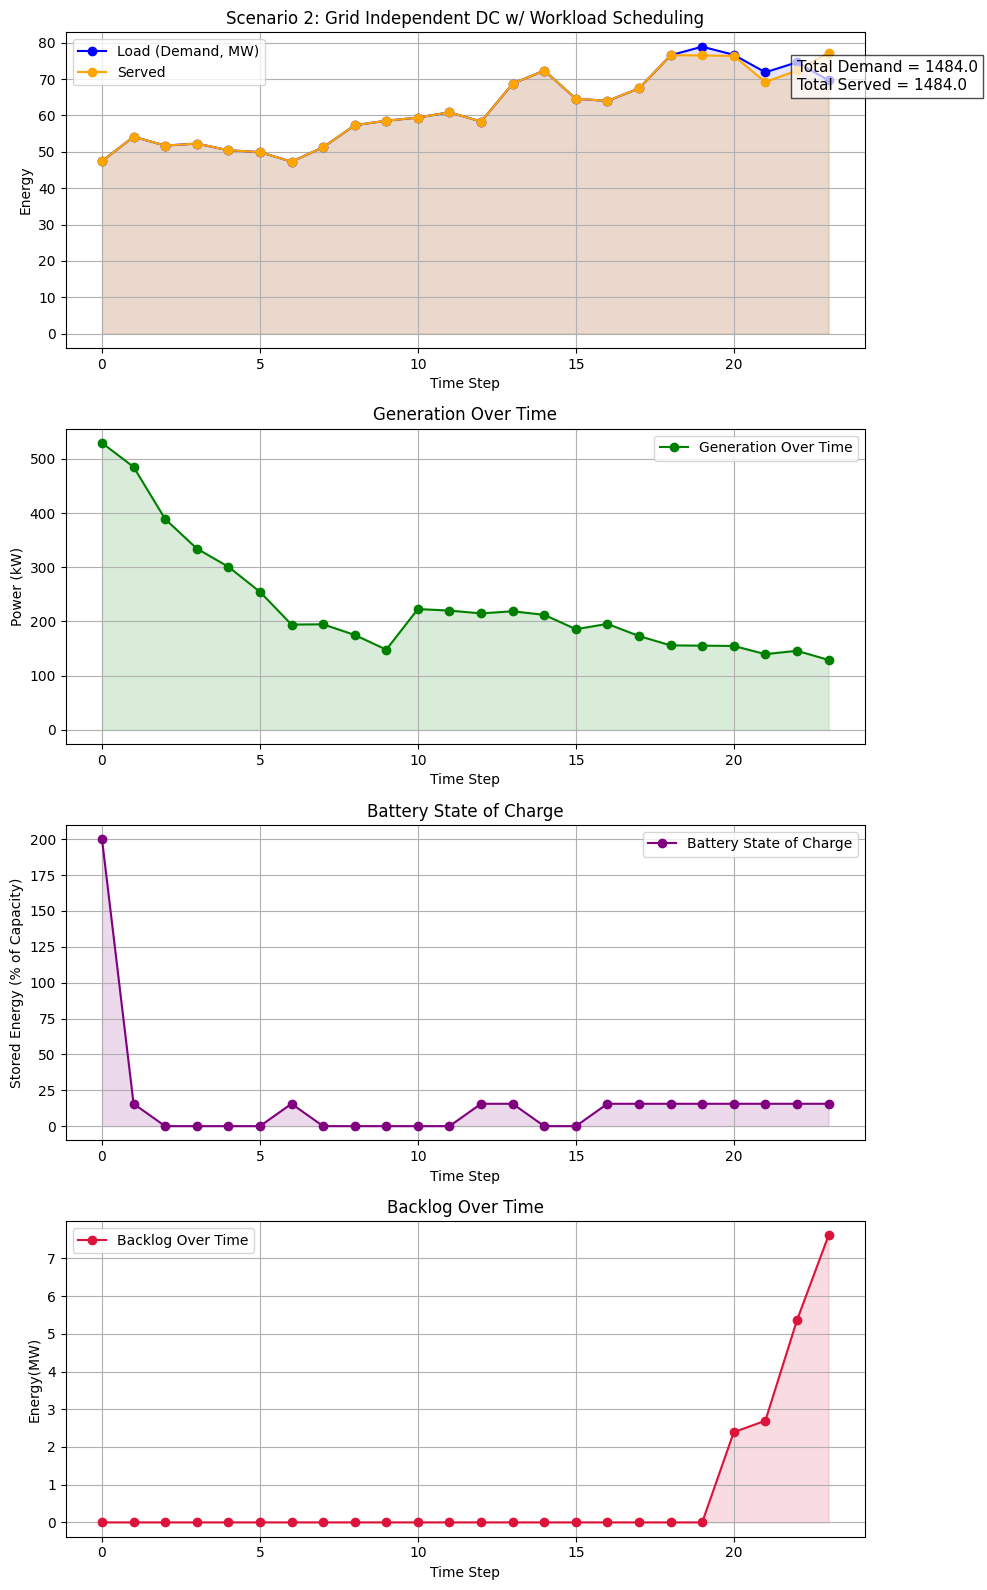

In [147]:


m2 = gp.Model("Cooling + Grid + Storage + Renewables Optimal Scheduling")
m2.setParam("OutputFlag",0)
solar_capacity_val = 1.0  # unit MW
wind_capacity_val = 1.0
battery_limit = m2.addVar(name="Battery Capacity",lb=0)
W, S, _, _ = get_data(renewable_path, weather_path, 8 , wind_capacity_val,solar_capacity_val,6200,21000,)

S_unit = interpolate_array(S)
W_unit = interpolate_array(W)

solar_capacity = m2.addVar(name="Solar Capacity",lb=0,)
wind_capacity = m2.addVar(name="Solar Capacity",lb=0)

T = 24#*365-1
u_r = m2.addVars(T,name= "u_r",lb=0) # power associated with renewable use
s_charge_r = m2.addVars(T,name="s_charge_r",lb=0) # charge associated with renewables
s_discharge = m2.addVars(T,name="s_discharge",lb=0) # discharge of battery, not associated with grid or renewables
x = m2.addVars(T+1,name="x",lb=0) # Backlog
c = m2.addVars(T+1,name="c",lb=0) #SoC
P_chiller = m2.addVars(T, name="P_chiller", lb=0) # cooling load
u = m2.addVars(T, name="u", lb=0) # computing load


#Initial Conditions
m2.addConstr(x[0]==0,"initial backlog")
m2.addConstr(c[0]==200,"inital storage")

#Terminal Conditions
# m2.addConstr(x[T] <= x[0], "terminal_backlog")

# Dynamics and constraints

m2.addConstrs((c[t+1] == c[t] + s_charge_r[t] - s_discharge[t] for t in range(T)), name="soc_update")
m2.addConstrs((c[t+1] <= battery_limit for t in range(T)), name="storage_capacity")
m2.addConstrs((s_discharge[t] <= c[t] for t in range(T)), name="max_discharge")
m2.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name="backlog_update")
m2.addConstrs((u[t] <= 100 for t in range(T)),name="compute_limit")
m2.addConstrs((COP[t]*P_chiller[t] >= u[t] for t in range(T)),name="cooling_req")
m2.addConstrs((u_r[t] + s_charge_r[t] == S_unit[t] * solar_capacity+W_unit[t]*wind_capacity for t in range(T)), name="renewables_balance")
m2.addConstrs((u_r[t] + s_discharge[t] == u[t] + P_chiller[t] + s_charge_r[t] for t in range(T)), name="energy_balance")
# for t_day in range(24, T+1, 24):  # at hour 24, 48, ..., T
m2.addConstr(c[T] == 0, "terminal_storage")
m2.addConstr(x[T] == 0, name=f"terminal_backlog")




m2.setObjective(gp.quicksum(r*x[t] for t in range(T))+CAPEX_Solar*solar_capacity+CAPEX_Storage*battery_limit + CAPEX_Wind*wind_capacity, GRB.MINIMIZE)

m2.optimize()


if m2.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 2:")
    generation_2 = [S_unit[t]*solar_capacity.X + W_unit[t]*wind_capacity.X for t in range(T)]
    served_2 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_2 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_2 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    print(f"Optimum wind capacity : {wind_capacity.X :.2f} MW")
    print(f"Optimum solar capacity : {solar_capacity.X :.2f} MW")
    print(f"AEP : {sum(generation_2) :.2f} MWh")
    print(f"Optimum battery capacity : {battery_limit.X :.2f} MW")
    print(f"Percent Energy lost: {(sum(generation_2)-sum(served_2))/(sum(generation_2))*100 :.2f} %")
    print(f"total demand served {sum(served_2) :.2f} MW")
    print(f"total actual demand: {sum(L):.2f} MW")
    print(f"Percentage of Demand Served: {sum(served_2)/sum(L[:T])*100 :.2f} %")
    solar_cost = CAPEX_Solar*solar_capacity.X/1e6
    battery_cost = CAPEX_Storage*max(soc_2)/1e6
    wind_cost = CAPEX_Wind*wind_capacity.X/1e6
    print(f"Solar Capex: $ {solar_cost :.2f} M")
    print(f"Wind Capex: $ {wind_cost :.2f} M")
    print(f"Storage CAPEX: $ {battery_cost :.2f} M")
    print(f"Total Costs: $ {solar_cost+battery_cost+wind_cost :.2f}M")
    plot_results("Scenario 2: Grid Independent DC w/ Workload Scheduling", served_2,L, soc=soc_2, generation=generation,backlog = backlog_2)


The main cost comes from capital expenditures, over time this might change

# Semi autonomous

In [ ]:
q = 1.0  # Cost per unit energy used
r =1  # Cost per unit backlog
k = 1  # Storage energy conversion factor
eta_c = 0.95
eta_d = 0.9
computing_limit = 100 # float("inf") #or switch to actual computing limit
battery_limit = 100.281  # float("inf") # or switch to actual computing limit
memory_limit = 60 # channe this for later




hours = np.arange(T)
T_ref, COP_ref = 25.0, 4.0
COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

m3 = gp.Model("Cooling + Grid + Storage + Renewables Optimal Scheduling")
m3.setParam("OutputFlag",0)
solar_capacity_val_3 = 1.0  # unit MW
wind_capacity_val_3 = 1.0
battery_limit_3 = m3.addVar(name="Battery Capacity",lb=0)
W, S, _, _ = get_data(renewable_path, weather_path, 8 , wind_capacity_val,solar_capacity_val,6200,21000,)

S_unit_3 = interpolate_array(S)
W_unit_3 = interpolate_array(W)

solar_capacity_3 = m3.addVar(name="Solar Capacity",lb=0,ub=0)
wind_capacity_3 = m3.addVar(name="Solar Capacity",lb=0,ub=400)


u_g = m3.addVars(T,name= "u_g",lb=0) # power associated with grid use
u_r = m3.addVars(T,name= "u_r",lb=0) # power associated with renewable use
s_charge_r = m3.addVars(T,name="s_charge_r",lb=0) # charge associated with renewables
s_charge_g = m3.addVars(T,name="s_charge_g",lb=0) # charge associated with grid
s_discharge = m3.addVars(T,name="s_discharge",lb=0) # discharge of battery, not associated with grid or renewables
x = m3.addVars(T+1,name="x",lb=0) # Backlog
c = m3.addVars(T+1,name="c",lb=0) #SoC
P_chiller = m3.addVars(T, name="P_chiller", lb=0) # cooling load
u = m3.addVars(T, name="u", lb=0) # computing load


#Initial Conditions
m3.addConstr(x[0]==0,"initial backlog")
m3.addConstr(c[0]==0,"inital storage")

#Terminal Conditions
m3.addConstr(c[T] >= 0, "terminal_storage")
m3.addConstr(x[T] <= x[0], "terminal_backlog")

# Dynamics and constraints
m3.addConstrs((c[t+1] == c[t] + eta_c*(s_charge_r[t] + s_charge_g[t]) - (1/eta_d)*(s_discharge[t]) for t in range(T)), name=f"soc_update")
m3.addConstrs((c[t+1] <= battery_limit for t in range(T)), name=f"storage_capacity")
m3.addConstrs((s_discharge[t] <= c[t] for t in range(T)), name=f"max_discharge")
m3.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name=f"backlog_update")
m3.addConstrs((x[t] <= memory_limit for t in range(T)), name=f"max_backlog")
m3.addConstrs((u[t] <= 100 for t in range(T)),name=f"compute_limit")
m3.addConstrs((COP[t]*P_chiller[t] >= u[t] for t in range(T)),name=f"cooling_req")
m3.addConstrs((u_r[t] + s_charge_r[t] == G[t] for t in range(T)),name=f"renewables_balance")
m3.addConstrs((u_g[t] + u_r[t] + s_discharge[t] == u[t] + P_chiller[t] + s_charge_r[t] + s_charge_g[t] for t in range(T)), name=f"energy_balance")


m3.setObjective(gp.quicksum(u_g[t]*C[t]*SCC + r*x[t] for t in range(T)), GRB.MINIMIZE)
m3.optimize()


if m3.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 3:")
    # for t in range(T):
    #     print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    # print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")

    served_3 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_3 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_3 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    emissions_3 = [u_g[t].X * C[t] for t in range(T)]

    plot_results("Combo DC", served_3, soc=soc_3, second_plot=True,backlog = backlog_3, carbon_intensity=C, emissions=emissions_3)


GurobiError: Constant is Nan